# Example evaluation of temperature-dependent I-V characteristics of a p-n diode

In this example, we load measurement data directly from the NOMAD upload, plot the data and extract the series resistance $R_\mathrm{S}$, the ideality factor $n$ as well as the bandgap of the semiconductor $E_\mathrm{gap}$. We use the following expression for the current of the diode (Shockley equation with contribution by a series resistance):

$$
I = I_\mathrm{S}\cdot\left[ \exp\left(\frac{e(V-R_\mathrm{S}I)}{nk_\mathrm{B}T}\right)-1\right]
$$

where the saturation current is temperature-dependent and approximately given by:

$$
I_\mathrm{S} = I_0 \cdot \exp\left(-\frac{E_\mathrm{gap}}{k_\mathrm{B}T}\right)
$$

with $V$ being the voltage applied to the diode, $T$ the temperature, $e$ the electron charge, and $k_\mathrm{B}$ the Boltzmann constant.

For further information, see for example the textbook S. M. Sze, Kwok K. Ng, Physics of Semiconductor Devices, 3rd edition, John Wiley & Sons (2007).

In [126]:
# First, let's import some packages; h5py is used to access the data in the nxs file (hdf5 format)

import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import scipy.constants as constants

## Open the file and load data

In [127]:
# This is the filename of the measurement data file as stored from NOMAD CAMELS in the current upload of NOMAD:
filename = 'CAMELS_data/diode1/data.nxs'

In [128]:
# Open the file and list all NOMAD CAMELS measurements contained in the file
file = h5py.File(filename, 'r')
keys = file.keys()
list(keys)

['Hacky_Hour_2024-03-18T12:47:11.810899+01:00']

In [129]:
# We select the first measurement of this list and display all the sections of data and metadata contained in the file
experiment = file[list(keys)[0]]
list(experiment.keys())

['data',
 'definition',
 'end_time',
 'experiment_description',
 'instrument',
 'plan_name',
 'plan_type',
 'process',
 'protocol_overview',
 'python_script',
 'sample',
 'scan_id',
 'start_time',
 'uid',
 'user',
 'variables']

In [130]:
# Get all measurement data of the temperature-dependent I-V sweep
dataset = experiment['data/IV_sweep']
temperatures = np.unique(np.array(dataset['PID_setpoint']))
data = [
    {
        'setpoint': temp,
        'temperature_avg': np.average(dataset['PID_current_value'][np.where(dataset['PID_setpoint'] == temp)]),
        'voltage': np.array(dataset['SMU_mesV1'][np.where(dataset['PID_setpoint'] == temp)]),
        'current': np.array(dataset['SMU_mesI1'][np.where(dataset['PID_setpoint'] == temp)]),
    }
    for temp in temperatures
]

## Plot the measurement data

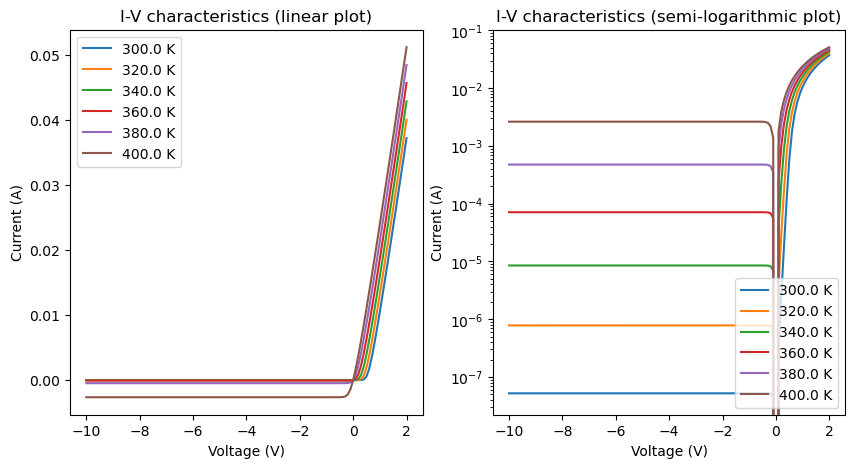

In [131]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
for i in [0, 1]:
    for curve in data:
        ax[i].plot(curve['voltage'], curve['current'] if i==0 else np.abs(curve['current']), label=str(curve['setpoint'])+' K')
    ax[i].set_xlabel('Voltage (V)')
    ax[i].set_ylabel('Current (A)')
    ax[i].legend()
ax[0].set_title('I-V characteristics (linear plot)')
ax[1].set_title('I-V characteristics (semi-logarithmic plot)')
ax[1].set_yscale('log')

## Determine the series resistance

Text(0.5, 1.0, 'I-V characteristics (only series resistance limited range)')

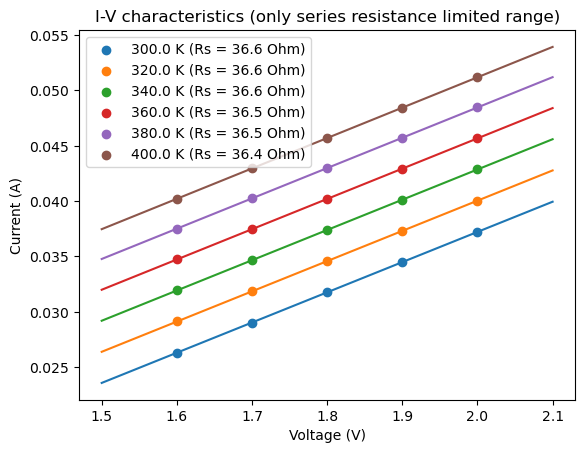

In [132]:
# Determine series resistance; we assume the I-V characteristics to be linear for voltages > 1.5 V

fig, ax = plt.subplots()
for idx, curve in enumerate(data):
    # only voltages > 1.5 V
    selection = np.where(curve['voltage'] > 1.5)

    # make a linear fit
    result = linregress(curve['voltage'][selection], curve['current'][selection])

    # plot the fit curve
    ax.plot([1.5, 2.1], result.slope * np.array([1.5, 2.1]) + result.intercept)
    Rs = 1 / result.slope
    ax.scatter(curve['voltage'][selection], curve['current'][selection], label=f"{curve['setpoint']} K (Rs = {Rs:.1f} Ohm)")
    data[idx]['series_resistance'] = Rs
    
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('Current (A)')
ax.legend()
ax.set_title('I-V characteristics (only series resistance limited range)')

## Determine the ideality factor

Text(0.5, 1.0, 'I-V characteristics (forward direction, corrected for series resistance)')

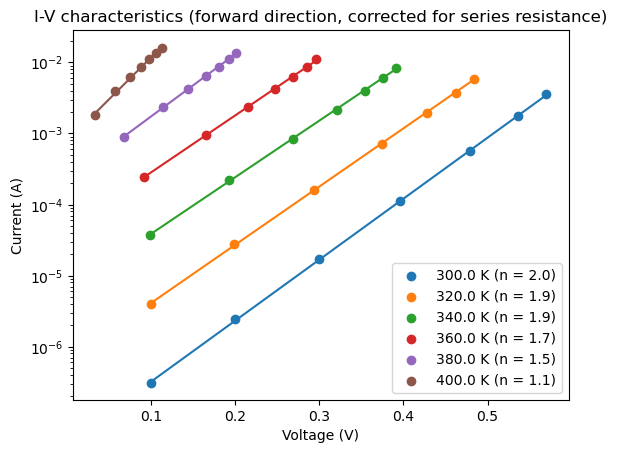

In [133]:
# Determine ideality factor; for this, we use data for forward voltages below 0.8 V and correct for the series resistance

fig, ax = plt.subplots()
for idx, curve in enumerate(data):
    # select the relevant data
    selection = np.where(np.logical_and(curve['voltage'] > 0, curve['voltage'] < 0.8))
    current = curve['current'][selection]
    voltage = curve['voltage'][selection] - curve['series_resistance'] * current

    # make a linear fit (on semilog scale)
    result = linregress(voltage, np.log(current))

    # plot the results
    ax.plot(voltage, np.exp(result.slope * voltage + result.intercept))
    n = constants.e / constants.k / curve['temperature_avg'] / result.slope
    ax.scatter(voltage, current, label=f"{curve['setpoint']} K (n = {n:.1f})")
    data[idx]['ideality_factor'] = n

ax.set_xlabel('Voltage (V)')
ax.set_ylabel('Current (A)')
ax.set_yscale('log')
ax.legend()
ax.set_title('I-V characteristics (forward direction, corrected for series resistance)')

## Determine the semiconductor bandgap of the diode

Text(2.6, 1e-07, 'Egap = 1.12 eV')

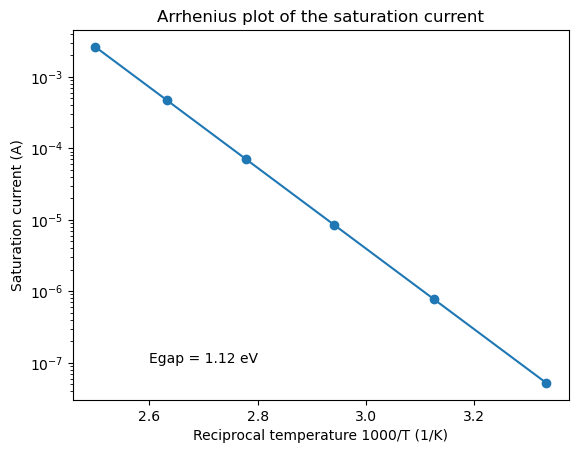

In [134]:
# Determine the semiconductor bandgap from the temperature-dependent saturation current (taken from the reverse currents for voltages < -2 V

# First, let's collect the saturation current data
Is = []
T = []
for idx, curve in enumerate(data):
    data[idx]['saturation_current'] = -np.average(curve['current'][np.where(curve['voltage'] < -2)])
    Is.append(data[idx]['saturation_current'])
    T.append(curve['temperature_avg'])
Is = np.array(Is)
T = np.array(T)

# and make a linear fit (on an Arrhenius plot, i.e. on a semilog scale vs. reciprocal temperature)
result = linregress(1000 / T, np.log(Is))

# plot the results
fig, ax = plt.subplots()
ax.scatter(1000 / T, Is)
ax.plot(1000 / T, np.exp(result.slope * 1000 / T + result.intercept))
ax.set_xlabel('Reciprocal temperature 1000/T (1/K)')
ax.set_ylabel('Saturation current (A)')
ax.set_yscale('log')
ax.set_title('Arrhenius plot of the saturation current')
Egap = -result.slope * constants.k / constants.e * 1000
ax.text(2.6, 1e-7, f"Egap = {Egap:.2f} eV")